In [ ]:
import torch
import os
from torch.utils import data
from PIL import Image
from torchvision import transforms
from collections import defaultdict
import json
import numpy as np

In [ ]:
torch.cuda.is_available()

False

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.flush_and_unmount()


In [ ]:
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
train_ims=os.listdir('/content/gdrive/MyDrive/train')

In [ ]:
os.path.exists('/content/gdrive/MyDrive/_annotations.coco.json')

True

In [ ]:
f=open('/content/gdrive/MyDrive/_annotations.coco.json')
print(len(json.loads(f.read())))

5


In [ ]:
import json
from collections import defaultdict
image_ids_annotations = defaultdict(list)
file=open('/content/gdrive/MyDrive/_annotations.coco.json','r+')
anns=json.loads(file.read())
for ann in anns['annotations']:
    image_id = ann['image_id'] # Are integers
    image_ids_annotations[image_id].append(ann)
print(image_ids_annotations[165])

[{'id': 205, 'image_id': 165, 'category_id': 30, 'bbox': [95, 14, 34, 44], 'area': 1496, 'segmentation': [], 'iscrowd': 0}, {'id': 206, 'image_id': 165, 'category_id': 30, 'bbox': [488, 88, 30, 43], 'area': 1290, 'segmentation': [], 'iscrowd': 0}, {'id': 207, 'image_id': 165, 'category_id': 30, 'bbox': [70, 482, 86, 105], 'area': 9030, 'segmentation': [], 'iscrowd': 0}]


In [ ]:
category_id_annots=[]
for ann in anns['categories']:
    category_id_annots.append(ann['name'])
print(category_id_annots)

['fight', 'AXA', 'Adidas', 'Animoca Brands', 'Betfred', 'Cadbury', 'Canon', 'Carlsberg', 'Casillero de Diablo', 'Chevrolet', 'Chivas', 'DHL', 'Dude Wipes', 'Ecolab', 'Etihad Airways', 'Expedia', 'Kohler', 'Laybuy', 'Marriot', 'Maui Jim', 'Melitta', 'Mlily', 'Nestle', 'Nike', 'Snapdragon', 'Standard Chartered', 'TeamViewer', 'Therabody.', 'Therabody_', 'Visit Malta', 'Wasabi']


In [ ]:
from pycocotools.coco import COCO

In [ ]:
len(list(sorted(COCO('/content/gdrive/MyDrive/_annotations.coco.json').imgs.keys())))

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


3552

In [ ]:
class Annot_Im(data.Dataset):
  def __init__(self,im_root,ann_root,transform):
    self.im_root=im_root
    self.ann_root=ann_root
    self.transform=transform
    self.ids=len(list(sorted(COCO('/content/gdrive/MyDrive/_annotations.coco.json').imgs.keys())))
  def __getitem__(self,index):
    image_ids_annotations = defaultdict(list)
    file=open(self.ann_root,'r+')
    anns=json.loads(file.read())
    for ann in anns['annotations']:
        image_id = ann['image_id'] # Are integers
        image_ids_annotations[image_id].append(ann)
    category_id_annots=defaultdict(list)
    for ann in anns['categories']:
        category_id_annots[ann['id']]=ann['name']
    annot_im=anns['images'][index]['file_name']
    if annot_im in os.listdir(self.im_root):
      img=Image.open(os.path.join('/content/gdrive/MyDrive/train',annot_im))
      image_anns = image_ids_annotations[index]
      for i in image_anns:
          bound=i['bbox']
          boxes=[]
          categories=[]
          areas=[]
          iscrowd=[]
          category=category_id_annots[i['category_id']]
          x=float(bound[0])
          y=float(bound[1])
          w=x+float(bound[2])
          h=y+float(bound[3])
          boxes.append([x,y,w,h])
          categories.append(i['category_id'])
          areas.append(i['area'])
          iscrowd.append(i['iscrowd'])
      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
      iscrowd = torch.zeros((self.ids,), dtype=torch.int64)
    else:
      return None
    annotations={}
    annotations["boxes"] = boxes
    annotations["labels"] = torch.tensor(categories, dtype=torch.int64)
    annotations['areas']=areas
    annotations['iscrowd']=iscrowd
    if self.transform is not None:
      img = self.transform(img)
    return img,annotations
  def __len__(self):
    return self.ids

In [ ]:
import torchvision
def get_transform():
  custom_transforms = []
  custom_transforms.append(torchvision.transforms.ToTensor())
  return torchvision.transforms.Compose(custom_transforms)

In [ ]:
model=Annot_Im('/content/gdrive/MyDrive/train','/content/gdrive/MyDrive/_annotations.coco.json',transform=get_transform())
print(model)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
my_dataset = Annot_Im('/content/gdrive/MyDrive/train','/content/gdrive/MyDrive/_annotations.coco.json',transform=get_transform())
def collate_fn(batch):
  return tuple(zip(*batch))
train_batch_size=1
data_loader = torch.utils.data.DataLoader(my_dataset
                                          ,batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [ ]:
os.path.exists('/content/gdrive/MyDrive/train/1200px-Nestle_textlogo_blue-svg_png.rf.816ed0e5efa6f30453be2f6cd3b7ff4e.jpg')

True

In [ ]:

dataiter=iter(data_loader)
data=dataiter.next()
features, labels=data
print(features[0].shape)
print(labels)

torch.Size([3, 640, 640])
({'boxes': tensor([[ 64., 379., 240., 489.]]), 'labels': tensor([7]), 'areas': tensor([19360.]), 'iscrowd': tensor([0, 0, 0,  ..., 0, 0, 0])},)


In [ ]:
device= torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patch
import numpy as np
trainloader=iter(data_loader)
images,labels1=trainloader.next()
images=images[0]
images=images.to(device)
print(labels1[0]['labels'][0])
def coord(i=0):
  return labels1[0]['boxes'][0][i]

tensor(20)


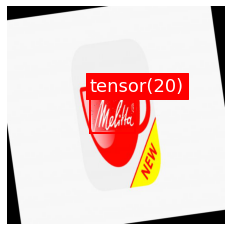

In [ ]:
def Image_disp(image):  
  fig,ax=plt.subplots()
  plt.text(coord(0)+1, coord(1)-5, labels1[0]['labels'][0],fontdict={'fontsize':18.0, 'fontweight':'medium','color': 'white', 'backgroundcolor':'red'})
  bb = patch.Rectangle((coord(0), coord(1)), coord(2)-coord(0), coord(3)-coord(1), linewidth=2, edgecolor='red', facecolor='none')
  ax.add_patch(bb)
  ax.axis('off')
  ax.imshow(image.permute(1,2,0))
  plt.show()
Image_disp(images.to('cpu'))

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

num_classes = 31
num_epochs = 10
model = get_model_instance_segmentation(num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

In [ ]:
torch.save(model,'/content/gdrive/MyDrive/new_model')

In [ ]:
torch.load('/content/gdrive/MyDrive/new_model'')
torch.eval()